### Question 1

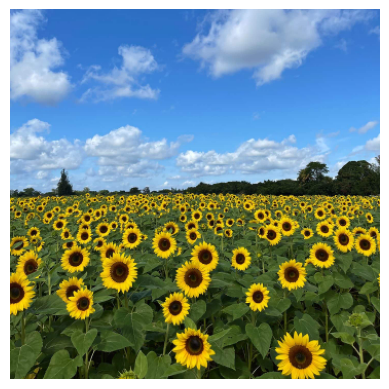

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("a2images/the_berry_farms_sunflower_field.jpeg", cv2.IMREAD_REDUCED_COLOR_4)
assert img is not None

plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

Parameters of the largest circle:
Center: (830, 671)
Radius: 289
Sigma value: 13.0


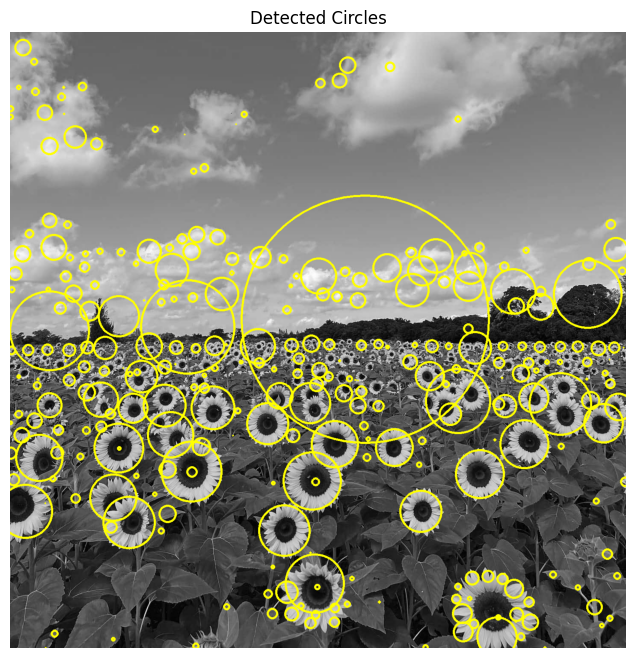

In [2]:
# Define the standard deviation (sigma) values for scale-space analysis
sigma_values = np.linspace(1, 13, 50)  # Adjust min_sigma, max_sigma, and num_sigma as needed
extrema_images = []

# Load the input grayscale image
image = cv2.imread("a2images/the_berry_farms_sunflower_field.jpeg", cv2.IMREAD_GRAYSCALE)

# Loop through each scale and compute the Laplacian response
for sigma in sigma_values:
    # Compute the size of the LoG kernel based on the scale
    kernel_size = int(6 * sigma)
    if kernel_size % 2 == 0:
        kernel_size += 1

    # Create a meshgrid for X and Y coordinates
    hw = (kernel_size - 1) // 2
    X, Y = np.meshgrid(np.arange(-hw, hw + 1, 1), np.arange(-hw, hw + 1, 1))

    # Compute the LoG kernel
    log_kernel = (1 / (2 * np.pi * sigma**2)) * (X**2 / (sigma**2) + Y**2 / (sigma**2) - 2) * np.exp(-(X**2 + Y**2) / (2 * sigma**2))

    # Compute the Laplacian of the LoG kernel
    laplacian_log_kernel = cv2.Laplacian(log_kernel, cv2.CV_64F)

    # Apply the LoG kernel to the image
    laplacian_response = cv2.filter2D(image, -1, laplacian_log_kernel)

    # Store the extrema image for this scale
    extrema_image = (laplacian_response > 0)  # Assuming extrema are positive in your case
    extrema_images.append(extrema_image)

# Calculate the absolute Laplacian values
abs_laplacian = np.abs(laplacian_response)

# Create a binary image where blobs are detected using the threshold
threshold = 0.1 # Adjust the threshold as needed
blob_mask = abs_laplacian > threshold * abs_laplacian.max()

# Find contours in the blob mask
contours, _ = cv2.findContours(blob_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize a list to store detected circles
circles = []

# Loop through the detected contours and fit circles to them
for contour in contours:
    if len(contour) >= 1:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        circles.append((center, radius, sigma))

# Sort the detected circles by radius in descending order
circles.sort(key=lambda x: -x[1])

# Report the parameters of the largest circle
largest_circle = circles[0]
center, radius, sigma = largest_circle

print("Parameters of the largest circle:")
print(f"Center: {center}")
print(f"Radius: {radius}")
print(f"Sigma value: {sigma}")

# Set the desired line thickness for drawn circles
line_thickness = 3

# Draw all detected circles with the specified line thickness on the original image
output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for circle in circles:
    center, radius, _ = circle
    cv2.circle(output_image, center, radius, (0, 255, 255), line_thickness)  # Red color

# Display the grayscale image with detected circles using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')
plt.title('Detected Circles')
plt.show()

### Qusetion 2

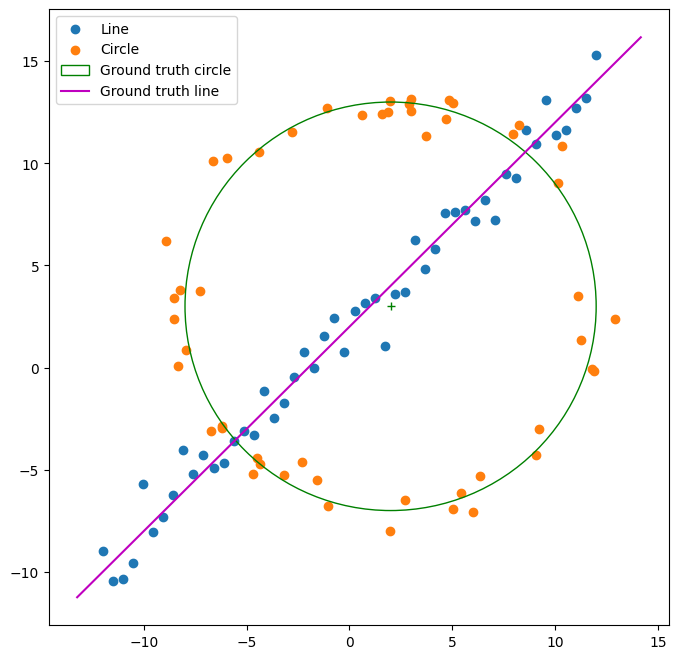

In [3]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np

# np.random.seed(0)
N = 100
half_n = N // 2

r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = 1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b

plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()
plt.show()

Best Line Parameters: a=0.7076883417640968, b=-0.706524741910135, d=1.1943013979593626, inliers=30


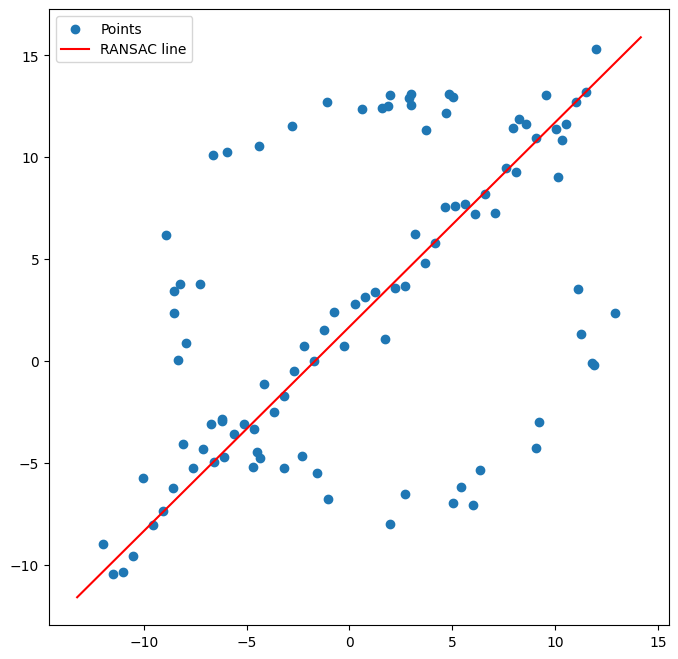

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute distance of points from a line
def compute_distances(points, a, b, d):
    # Using |a*x + b*y + d| since [a,b] is a unit vector (constraint ∥[a,b]∥=1)
    distances = np.abs(a * points[:, 0] + b * points[:, 1] + d)
    return distances

# Function to fit a line from two points
def fit_line_from_points(p1, p2):
    # The line through p1=(x1, y1) and p2=(x2, y2)
    # Ax + By + C = 0, where (A,B) is the normal vector to the line
    delta_x = p2[0] - p1[0]
    delta_y = p2[1] - p1[1]
    
    # Normal vector to the line (A,B) = (-delta_y, delta_x)
    a = -delta_y
    b = delta_x
    
    # Normalize [a, b] to satisfy ∥[a, b]∥=1
    norm = np.sqrt(a**2 + b**2)
    a /= norm
    b /= norm
    
    # Distance from the origin (perpendicular distance)
    d = -(a * p1[0] + b * p1[1])
    
    return a, b, d

# RANSAC algorithm
def ransac_line_fitting(points, num_iterations, distance_threshold, min_inliers):
    best_a, best_b, best_d = None, None, None
    best_inliers_count = 0
    n_points = points.shape[0]
    
    for _ in range(num_iterations):
        # Randomly sample two points
        random_indices = np.random.choice(n_points, 2, replace=False)
        p1, p2 = points[random_indices]
        
        # Fit a line using the two points
        a, b, d = fit_line_from_points(p1, p2)
        
        # Compute distances of all points from the line
        distances = compute_distances(points, a, b, d)
        
        # Identify inliers (points within the distance threshold)
        inliers = points[distances < distance_threshold]
        inliers_count = inliers.shape[0]
        
        # Update the best model if this one has more inliers
        if inliers_count > best_inliers_count and inliers_count >= min_inliers:
            best_a, best_b, best_d = a, b, d
            best_inliers_count = inliers_count
    
    return best_a, best_b, best_d, best_inliers_count

# Parameters for RANSAC
num_iterations = 1000
distance_threshold = 0.5  # Distance threshold to consider a point an inlier
min_inliers = 5  # Minimum number of inliers to accept the model

# Run RANSAC on the noisy points
best_a, best_b, best_d, best_inliers_count = ransac_line_fitting(X, num_iterations, distance_threshold, min_inliers)

print(f"Best Line Parameters: a={best_a}, b={best_b}, d={best_d}, inliers={best_inliers_count}")

# Plotting the result
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='Points')

# Plot the best line found by RANSAC
x_vals = np.array(ax.get_xlim())
y_vals = -(best_a * x_vals + best_d) / best_b
ax.plot(x_vals, y_vals, color='red', label='RANSAC line')

plt.legend()
plt.show()

Best Circle Parameters: xc=1.5410591794824444, yc=2.9515194652197723, r=10.065204504372117, inliers=29


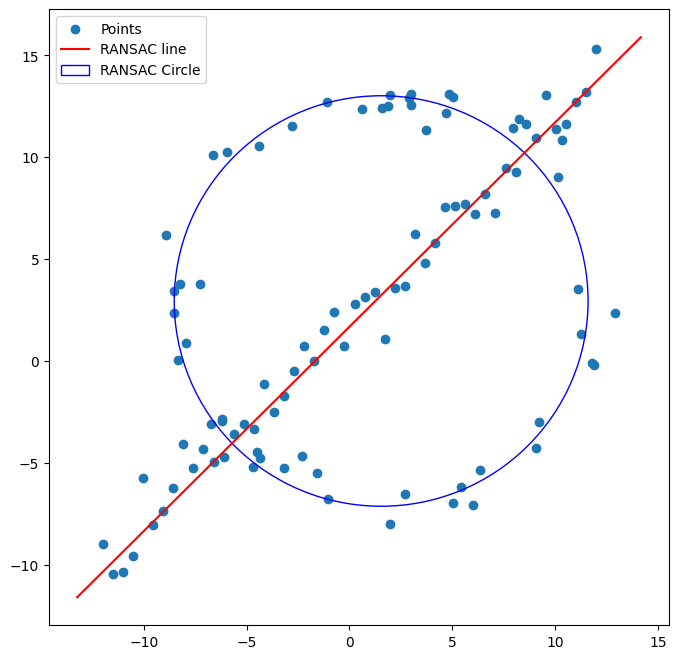

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the center and radius of a circle given 3 points
def circle_from_points(p1, p2, p3):
    # Using the equations of the perpendicular bisectors of the lines formed by p1-p2 and p2-p3
    A = np.array([[p2[0] - p1[0], p2[1] - p1[1]], [p3[0] - p2[0], p3[1] - p2[1]]])
    b = np.array([0.5 * (p2[0]**2 - p1[0]**2 + p2[1]**2 - p1[1]**2), 0.5 * (p3[0]**2 - p2[0]**2 + p3[1]**2 - p2[1]**2)])
    center = np.linalg.solve(A, b)
    
    # Radius is the distance from the center to any of the points (we choose p1)
    radius = np.sqrt((center[0] - p1[0])**2 + (center[1] - p1[1])**2)
    
    return center[0], center[1], radius

# Function to compute radial distance of points from the circle
def radial_distances(points, xc, yc, r):
    distances = np.sqrt((points[:, 0] - xc)**2 + (points[:, 1] - yc)**2)
    radial_error = np.abs(distances - r)
    return radial_error

# RANSAC algorithm for circle fitting
def ransac_circle_fitting(points, num_iterations, distance_threshold, min_inliers):
    best_xc, best_yc, best_r = None, None, None
    best_inliers_count = 0
    n_points = points.shape[0]
    
    for _ in range(num_iterations):
        # Randomly sample three points
        random_indices = np.random.choice(n_points, 3, replace=False)
        p1, p2, p3 = points[random_indices]
        
        # Fit a circle using the three points
        try:
            xc, yc, r = circle_from_points(p1, p2, p3)
        except np.linalg.LinAlgError:
            # Skip if the points are collinear and cannot define a circle
            continue
        
        # Compute radial distances of all points from the circle
        radial_error = radial_distances(points, xc, yc, r)
        
        # Identify inliers (points within the radial error threshold)
        inliers = points[radial_error < distance_threshold]
        inliers_count = inliers.shape[0]
        
        # Update the best model if this one has more inliers
        if inliers_count > best_inliers_count and inliers_count >= min_inliers:
            best_xc, best_yc, best_r = xc, yc, r
            best_inliers_count = inliers_count
            best_sample_points = [p1, p2, p3]

    return best_xc, best_yc, best_r, best_inliers_count, np.array(best_sample_points)


# Subtract the line inliers to get the remnant (circle points)
line_inliers = compute_distances(X, best_a, best_b, best_d) < distance_threshold
X_remnant = X[~line_inliers]

# Parameters for RANSAC circle fitting
circle_num_iterations = 1000
circle_distance_threshold = 0.5  # Radial error threshold to consider a point an inlier
circle_min_inliers = 20  # Minimum number of inliers to accept the circle model

# Run RANSAC for circle fitting on the remnant points
best_xc, best_yc, best_r, best_circle_inliers_count, best_sample_points = ransac_circle_fitting(X_remnant, circle_num_iterations, circle_distance_threshold, circle_min_inliers)

print(f"Best Circle Parameters: xc={best_xc}, yc={best_yc}, r={best_r}, inliers={best_circle_inliers_count}")

# Plotting the result
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='Points')

# Plot the best line found by RANSAC
x_vals = np.array(ax.get_xlim())
y_vals = -(best_a * x_vals + best_d) / best_b
ax.plot(x_vals, y_vals, color='red', label='RANSAC line')

# Plot the best circle found by RANSAC
circle_plot = plt.Circle((best_xc, best_yc), best_r, color='blue', fill=False, label='RANSAC Circle')
ax.add_patch(circle_plot)

plt.legend()
plt.show()

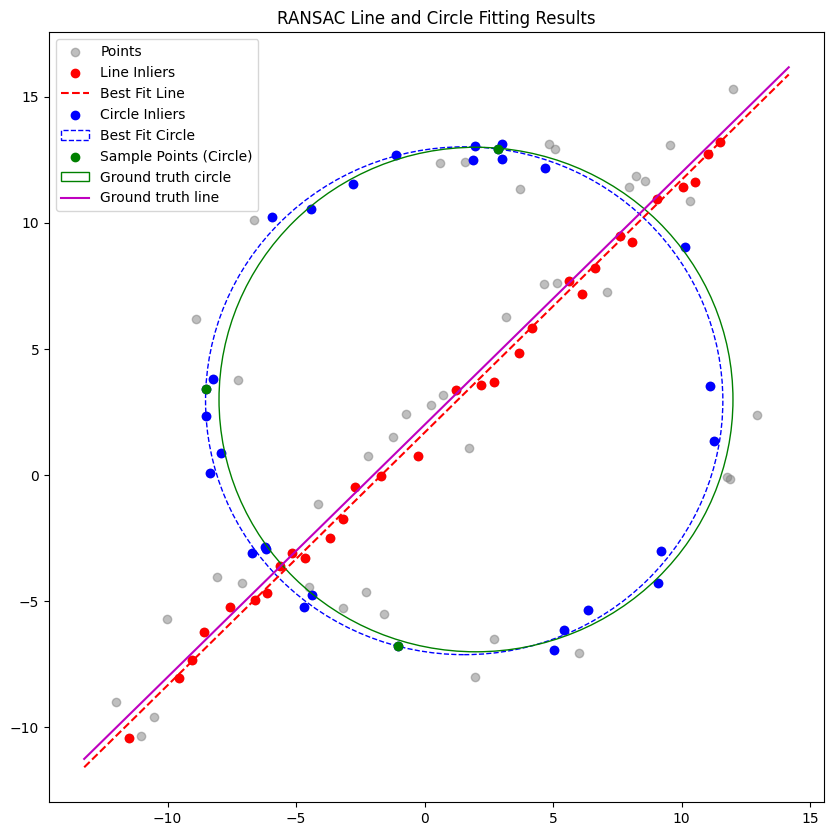

In [6]:
# Create the plot
def plot_ransac_results(X, best_a, best_b, best_d, best_xc, best_yc, best_r, best_sample_points, line_inliers, circle_inliers):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the point set
    ax.scatter(X[:, 0], X[:, 1], color='gray', label='Points', alpha=0.5)
    
    # Plot the line inliers
    ax.scatter(X[line_inliers, 0], X[line_inliers, 1], color='red', label='Line Inliers')
    
    # Plot the best estimate line
    x_vals = np.array(ax.get_xlim())
    y_vals = -(best_a * x_vals + best_d) / best_b
    ax.plot(x_vals, y_vals, 'r--', label='Best Fit Line')
    
    # Plot the circle inliers
    ax.scatter(X_remnant[circle_inliers, 0], X_remnant[circle_inliers, 1], color='blue', label='Circle Inliers')
    
    # Plot the best estimate circle
    circle_plot = plt.Circle((best_xc, best_yc), best_r, color='blue', fill=False, linestyle='--', label='Best Fit Circle')
    ax.add_patch(circle_plot)
    
    # Plot the three points that defined the circle
    ax.scatter(best_sample_points[:, 0], best_sample_points[:, 1], color='green', marker='o', label='Sample Points (Circle)', zorder=5)
    
    circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
    ax.add_patch(circle_gt)
    
    plt.plot(x_, y_, color='m', label='Ground truth line')

    plt.legend()
    plt.title("RANSAC Line and Circle Fitting Results")
    plt.show()


# Find circle inliers based on the best circle
circle_inliers = radial_distances(X_remnant, best_xc, best_yc, best_r) < circle_distance_threshold

# Plot the final results
plot_ransac_results(X, best_a, best_b, best_d, best_xc, best_yc, best_r, best_sample_points, line_inliers, circle_inliers)

### Question 3

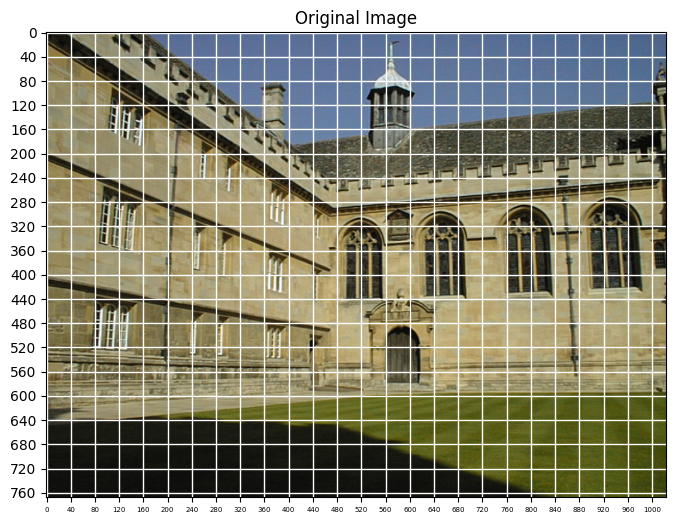

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("a2images/005.jpg")
assert img is not None

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.xticks(np.arange(0, img.shape[1], 40), fontsize=5)
plt.yticks(np.arange(0, img.shape[0], 40))
plt.grid(True, color='white', linewidth=1)
plt.show()

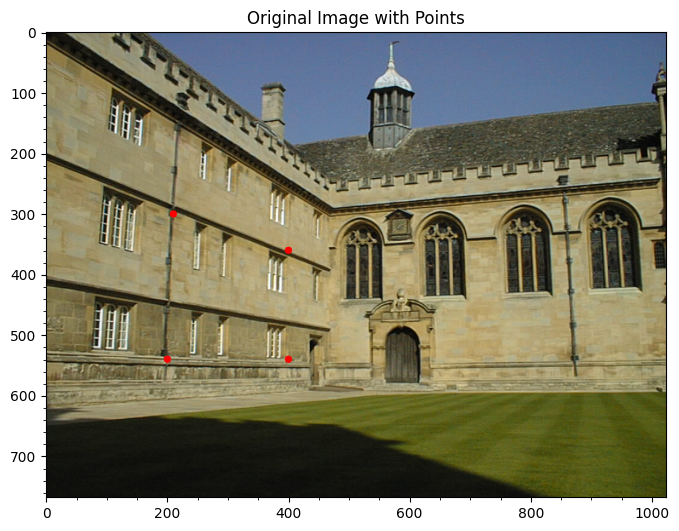

In [8]:
points_img = np.array([[210,300], [200,540], [400,360], [400,540]], dtype='float32')

img2 = img.copy()
# Specify the dot properties
color = (0, 0, 255)  # red color in BGR
radius = 6               # Radius of the dot
thickness = -1           # Thickness of the dot (filled)

# Draw dots on the image
for center_coordinates in points_img:
    # Draw the dot on the image
    cv2.circle(img2, (int(center_coordinates[0]), int(center_coordinates[1])), radius, color , thickness)

# Display the image using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Original Image with Points')

plt.minorticks_on()  # Enable minor ticks
#plt.grid(which='minor', color='white')
plt.show()

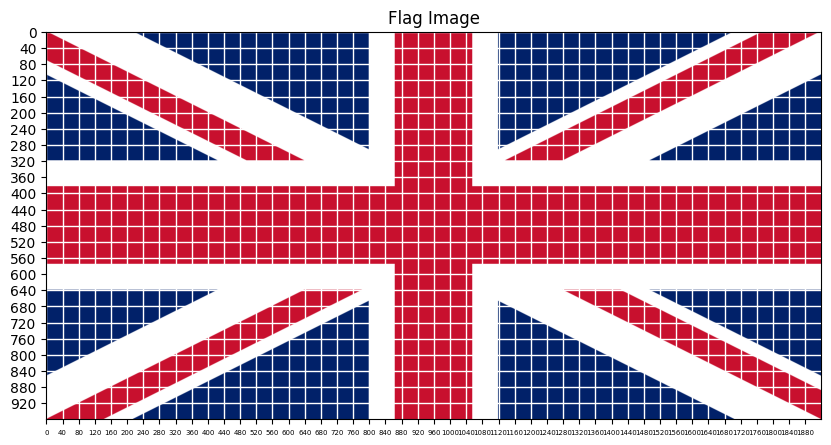

(960, 1920, 3)

In [9]:
flag_img = cv2.imread("a2images/flag.png")
assert img is not None

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(flag_img, cv2.COLOR_BGR2RGB))
plt.title('Flag Image')
plt.xticks(np.arange(0, flag_img.shape[1], 40), fontsize=5)
plt.yticks(np.arange(0, flag_img.shape[0], 40))
plt.grid(True, color='white', linewidth=1)
plt.grid(True)
plt.show()

flag_img.shape

In [10]:
points_flag = np.array([[0, 0], [0,959], [1919,0], [1919,959]], dtype='float32')

def compute_homography(src_pts, dst_pts):

    assert src_pts.shape == dst_pts.shape, "Source and destination points must have the same shape."
    assert src_pts.shape[0] >= 4, "At least 4 points are required to compute the homography."
    num_points = src_pts.shape[0]

    A = []
    for i in range(num_points):
        x_src, y_src = src_pts[i][0], src_pts[i][1]
        x_dst, y_dst = dst_pts[i][0], dst_pts[i][1]

        # Two rows per correspondence
        A.append([-x_src, -y_src, -1, 0, 0, 0, x_dst * x_src, x_dst * y_src, x_dst])
        A.append([0, 0, 0, -x_src, -y_src, -1, y_dst * x_src, y_dst * y_src, y_dst])

    A = np.array(A)

    AtA = np.dot(A.T, A)

    # Eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eig(AtA)
    # Get the eigenvector corresponding to the smallest eigenvalue
    smallest_eigenvalue_index = np.argmin(eigenvalues)
    h = eigenvectors[:, smallest_eigenvalue_index]

    # Reshape h into the 3x3 homography matrix
    H = h.reshape(3, 3)
    # Normalize H (if necessary, to make H[2,2] = 1)
    return H

H = compute_homography(points_flag, points_img)
print(H)

[[-4.60107536e-04  5.69501505e-05 -5.73459994e-01]
 [-2.56142315e-04 -6.06519651e-04 -8.19228619e-01]
 [-4.74337620e-07  1.42375381e-07 -2.73076200e-03]]


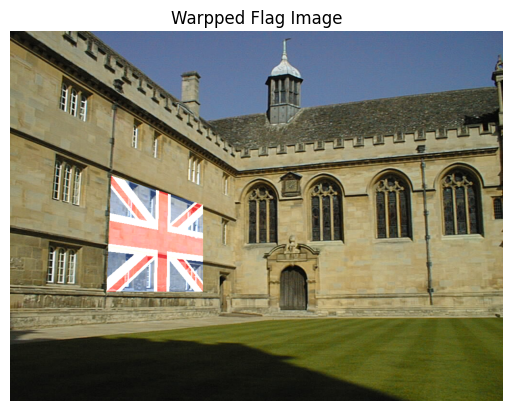

In [11]:
architecture = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
flag = cv2.cvtColor(flag_img, cv2.COLOR_BGR2RGB)

# Compute the homography
# Warp the flag image to fit the architectural plane
height, width, channels = architecture.shape
warped_flag = cv2.warpPerspective(flag, H, (width, height))

bg_img = np.ones((height, width, channels), dtype=np.uint8) * 255
# Blend the images
blended_image = cv2.addWeighted(warped_flag, 0.9, architecture , 1, 0)

plt.imshow(blended_image)
plt.axis('off')
plt.title('Warpped Flag Image')
plt.show()

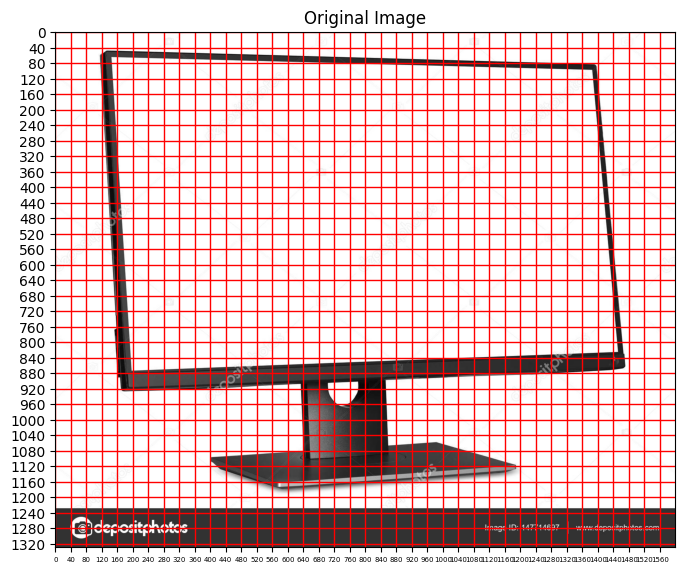

In [12]:
monitor_img = cv2.imread("a2images/monitor.jpg")
assert monitor_img is not None

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(monitor_img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.xticks(np.arange(0, monitor_img.shape[1], 40), fontsize=5)
plt.yticks(np.arange(0, monitor_img.shape[0], 40))
plt.grid(True, color='red', linewidth=1)
plt.show()

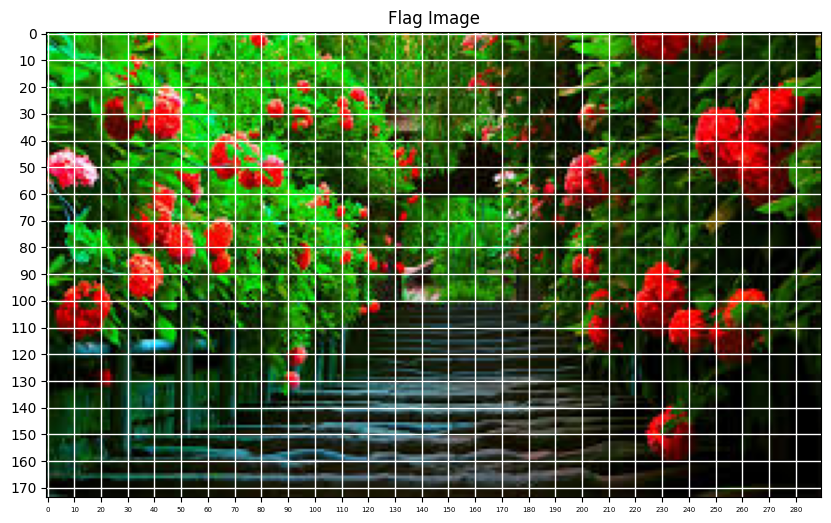

In [13]:
wallpaper = cv2.imread("a2images/wallpaper.jpeg")
assert wallpaper is not None

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(wallpaper, cv2.COLOR_BGR2RGB))
plt.title('Flag Image')
plt.xticks(np.arange(0, wallpaper.shape[1], 10), fontsize=5)
plt.yticks(np.arange(0, wallpaper.shape[0], 10))
plt.grid(True, color='white', linewidth=1)
plt.grid(True)
plt.show()

In [14]:
points_monitor = np.array([[140, 60], [200, 880], [1400, 80], [1460, 840]], dtype='float32')
points_wallpaper = np.array([[0, 0], [0,170], [290,0], [290, 170]], dtype='float32')
H1 = compute_homography(points_wallpaper, points_monitor)
H1

array([[-3.09900801e-02, -2.28591623e-03, -9.18224598e-01],
       [-5.94810512e-04, -3.15089927e-02, -3.93524827e-01],
       [-1.78103908e-06,  1.44678277e-07, -6.55874710e-03]])

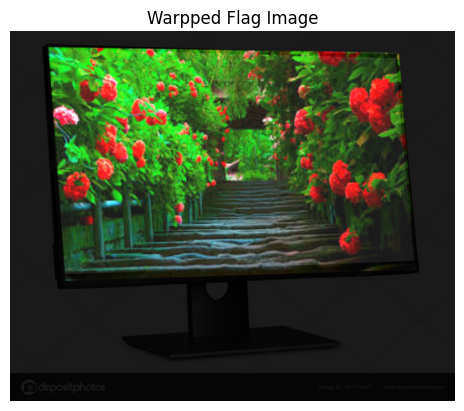

In [15]:
background = cv2.cvtColor(monitor_img, cv2.COLOR_BGR2RGB)
wall = cv2.cvtColor(wallpaper, cv2.COLOR_BGR2RGB)

# Compute the homography
height, width, channels = background.shape
warped_wall = cv2.warpPerspective(wall, H1, (width, height))

bg_img = np.ones((height, width, channels), dtype=np.uint8) * 255
# Blend the images
blend_image = cv2.addWeighted(warped_wall, 1, background , 0.1, 0)

plt.imshow(blend_image)
plt.axis('off')
plt.title('Warpped Flag Image')
plt.show()

### Question 4

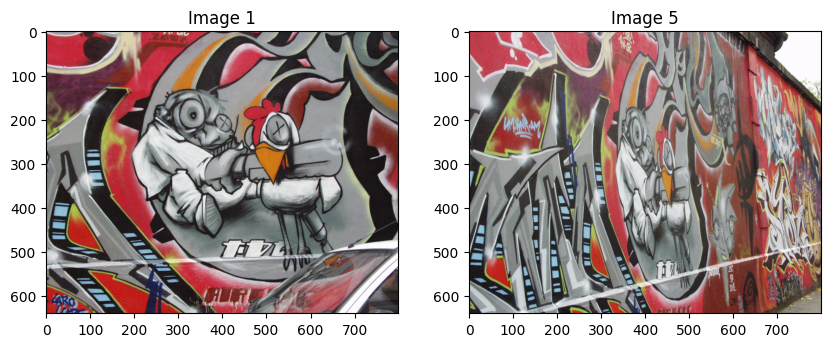

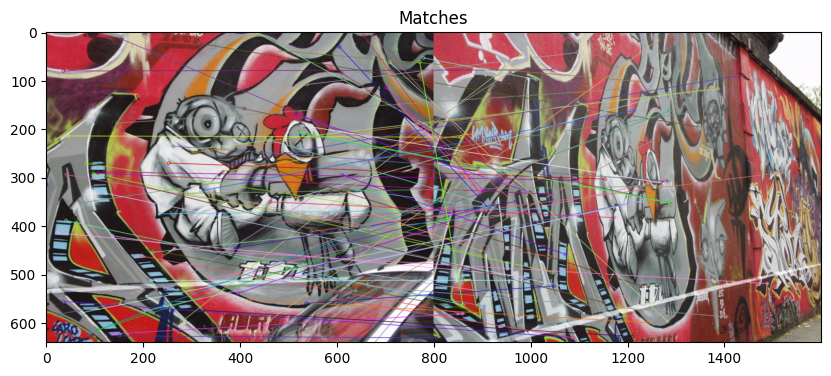

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img1 = cv2.imread('a2images/graf/img1.ppm', cv2.IMREAD_ANYCOLOR)
img5 = cv2.imread('a2images/graf/img5.ppm', cv2.IMREAD_ANYCOLOR)

# Plot the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Image 1')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Image 5')
plt.imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
plt.show()

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors in both images
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints5, descriptors5 = sift.detectAndCompute(img5, None)

# Create a brute-force matcher
bf = cv2.BFMatcher()

# Match descriptors
matches = bf.knnMatch(descriptors1, descriptors5, k=2)

# Apply Lowe's ratio test to filter good matches
good_matches = []
pts1 = []
pts2 = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
        pts1.append(keypoints1[m.queryIdx].pt)
        pts2.append(keypoints5[m.trainIdx].pt)

# Draw the matches
match_img = cv2.drawMatches(img1, keypoints1, img5, keypoints5, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Save the image with matches
cv2.imwrite('matches.jpg', match_img)

# Change the image to RGB color space
#match_img = cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB)

# Plot the image with matches
plt.figure(figsize=(10, 10))
plt.title('Matches')
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.show()

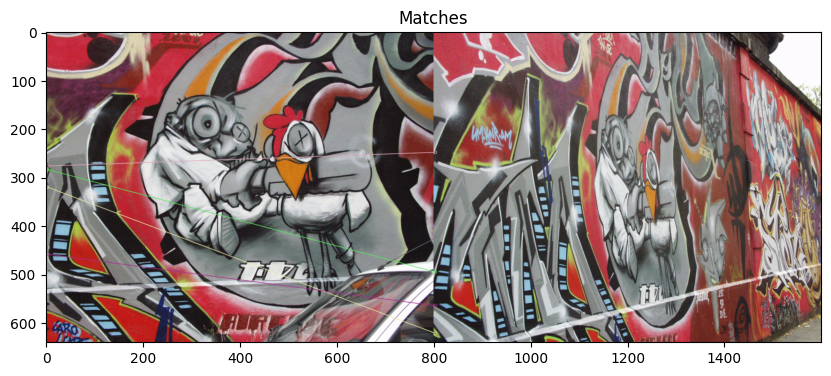

Homography Matrix:
[[-2.06290407e-01  2.51828474e-02  1.02767354e+02]
 [-1.38262699e-01 -3.29410682e-03  6.87286197e+01]
 [-1.72925096e-03 -3.85090742e-04  1.00000000e+00]]
 
Original Homography Matrix:
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


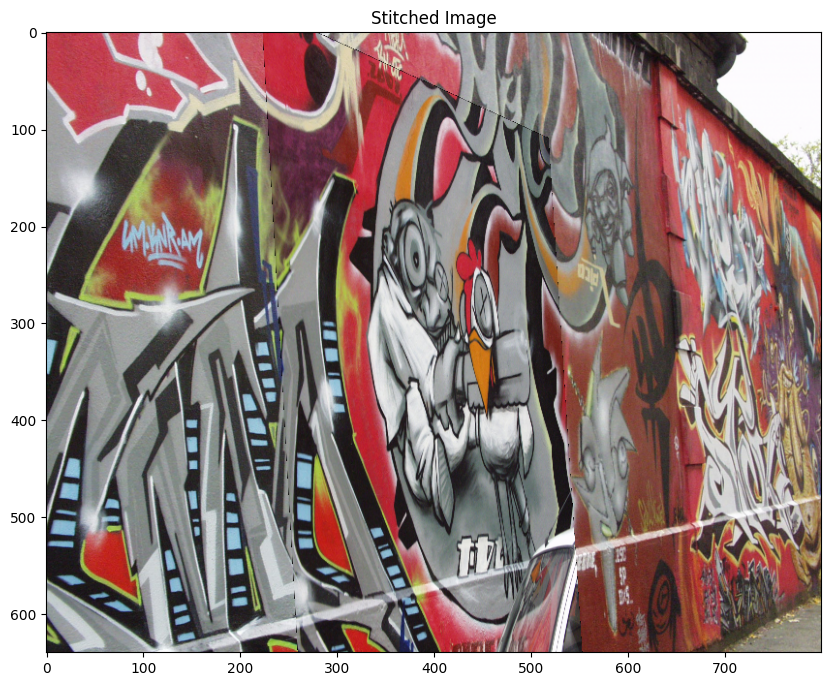

In [17]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def ransac_matching(img1, img2, num_iterations=1000, max_distance=10, min_inliers=100):
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors in both images
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img5, None)

    # Create a brute-force matcher
    bf = cv2.BFMatcher()

    best_matches = []  # Store the best matches found by RANSAC
    best_homography = None  # Store the best homography matrix
    best_inliers = []  # Store the inliers of the best model

    for _ in range(num_iterations):
        # Randomly select four matches
        random_matches = random.sample(range(len(keypoints1)), 4)

        # Get the keypoints for the selected matches
        src_pts = np.float32([keypoints1[m].pt for m in random_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m].pt for m in random_matches]).reshape(-1, 1, 2)
        

        # Compute the homography matrix
        homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, max_distance)

        # Transform keypoints from img1 to img2 using the computed homography
        transformed_pts = cv2.perspectiveTransform(src_pts, homography)

        # Calculate the Euclidean distances between transformed and actual keypoints in img2
        distances = np.sqrt(np.sum((dst_pts - transformed_pts) ** 2, axis=2))

        # Count the number of inliers (matches within a certain distance threshold)
        inliers = np.count_nonzero(distances < max_distance)

        # Update if this model has more inliers than the current best
        if inliers > len(best_inliers):
            best_inliers = distances < max_distance
            best_matches = random_matches
            best_homography = homography

        # If we have enough inliers, exit early
        if inliers >= min_inliers:
            break

    # Filter the best matches using inliers
    filtered_matches = [cv2.DMatch(i, i, 0) for i, is_inlier in enumerate(best_inliers) if is_inlier]

    return filtered_matches, best_homography, keypoints1, keypoints2


# Find matching points using custom RANSAC
matches, homography, keypoints1, keypoints2 = ransac_matching(img1, img5)

# Draw the matching points
matched_img = cv2.drawMatches(img1, keypoints1, img5, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show the image with matches
plt.figure(figsize=(10, 10))
plt.title('Matches')
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.show()

print("Homography Matrix:")
print(homography)

print(" ")

# Load homography matrix from file
homography = np.loadtxt("a2images/graf/H1to5p")
# Print the original homography matrix
print("Original Homography Matrix:")
print(homography)

# Warp img1 onto img5 using the homography
img1_warped = cv2.warpPerspective(img1, homography, (img5.shape[1], img5.shape[0]))

# Create a binary mask of the warped image
_, img1_mask = cv2.threshold(cv2.cvtColor(img1_warped, cv2.COLOR_BGR2GRAY), 1, 255, cv2.THRESH_BINARY)

# Invert the mask to get the region where img1 should be placed
img5_mask = cv2.bitwise_not(img1_mask)

# Blend the two images together
result = cv2.bitwise_and(img5, img5, mask=img5_mask)
result = cv2.add(result, img1_warped)

# Display the stitched image
plt.figure(figsize=(10, 10))
plt.title('Stitched Image')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()